# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import activations
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D

# Import the Dataset

In [3]:
data = pd.read_csv("cleaned_text.csv", encoding='latin1', header = 0)
data.head()

,Unnamed: 0,tweet,punctuation_count,sentiment
0,0,sleep good remedi fall asleep need one,6,0
1,1,work fun,2,0
2,2,summer person love dull cold weather centralco...,3,1
3,3,want smoke cig lighter,2,0
4,4,pass lot twit arriv trend topic bob,8,0


# Preparing the Dataset

In [4]:
#Droping columnns we dont need for the NN model
data.drop(data.columns[[0]], axis=1, inplace=True)
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0


In [5]:
data.sentiment.value_counts() # dataset is already balanced

0    52657
1    52584
Name: sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

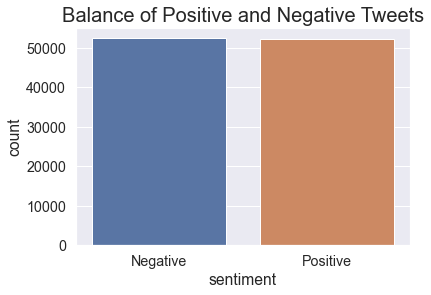

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.3)
plot = sns.countplot(x = 'sentiment', data = data)
plot.set_title("Balance of Positive and Negative Tweets", fontsize=20)
plot.set_xticklabels(['Negative','Positive'])


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105241 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  105241 non-null  int64 
 2   sentiment          105241 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


In [21]:
data.dropna(subset = ["tweet"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104742 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  104742 non-null  int64 
 2   sentiment          104742 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


# Tokenize

In [22]:
#Keeping the labels and creating preparing text for tfidf vectorizer
Y = data[['sentiment']]
X = data.drop(['sentiment'], axis=1)
X.head()

,tweet,punctuation_count
0,sleep good remedi fall asleep need one,6
1,work fun,2
2,summer person love dull cold weather centralco...,3
3,want smoke cig lighter,2
4,pass lot twit arriv trend topic bob,8


In [23]:
tweet = X[['tweet']]

punctuation_counts = X[['punctuation_count']]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words="english", max_features=8000)

tfidf_vect = vectorizer.fit_transform(X['tweet'])
tfidf_feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame (tfidf_vect.todense())
tfidf_df.columns = tfidf_feature_names
tfidf_df['punctuation_count'] = punctuation_counts

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection

min_max_scaler = preprocessing.MinMaxScaler()
tfidf_df['punctuation_count'] = min_max_scaler.fit_transform(punctuation_counts)

In [26]:
tfidf_df.shape

(104742, 8001)

# Split Data

In [69]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf_df,
                                                Y,
                                                test_size=0.2,
                                                random_state=10)

In [70]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((83793, 8001), (20949, 8001), (83793, 1), (20949, 1))

In [71]:
# size/shape of dataframe
n_samples = Xtrain.shape[0]
n_featuers = Xtrain.shape[1]

# Model 1 Sequential NN with TFIDF

In [92]:
# Importing the Keras libraries and packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model = keras.Sequential(
    [
        layers.Dense(3000, activation='relu', name='layer1'),
        layers.Dropout(0.5),
        layers.Dense(200, activation='sigmoid', name='layer2'),
        layers.Dropout(0.5),
        layers.Dense(40, activation='sigmoid', name='layer3'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', name='output1'),
    ]
)

In [88]:
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0, clipvalue=0.5, name="Adam")

In [93]:
# Compiling the ANN
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [94]:
model_save_filename = "twitter_model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)


history = model.fit(
                    Xtrain, 
                    ytrain, 
                    batch_size=10000,
                    epochs=100, 
                    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
                    validation_data = (Xtest, ytest)
                    )

Epoch 1/100
9/9 [==============================] - 11s 973ms/step - loss: 0.7567 - accuracy: 0.5012 - val_loss: 0.6903 - val_accuracy: 0.5614
Epoch 2/100
9/9 [==============================] - 4s 405ms/step - loss: 0.7223 - accuracy: 0.5106 - val_loss: 0.6790 - val_accuracy: 0.6487
Epoch 3/100
9/9 [==============================] - 4s 398ms/step - loss: 0.6848 - accuracy: 0.5573 - val_loss: 0.6512 - val_accuracy: 0.7382
Epoch 4/100
9/9 [==============================] - 4s 399ms/step - loss: 0.6333 - accuracy: 0.6595 - val_loss: 0.5800 - val_accuracy: 0.7402
Epoch 5/100
9/9 [==============================] - 3s 393ms/step - loss: 0.5558 - accuracy: 0.7326 - val_loss: 0.5157 - val_accuracy: 0.7470
Epoch 6/100
9/9 [==============================] - 4s 396ms/step - loss: 0.5106 - accuracy: 0.7613 - val_loss: 0.5084 - val_accuracy: 0.7547
Epoch 7/100
9/9 [==============================] - 4s 397ms/step - loss: 0.4881 - accuracy: 0.7768 - val_loss: 0.5029 - val_accuracy: 0.7572
Epoch 8/100


In [ ]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 128, 32)           160064    
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 64, 100)           3300      
_________________________________________________________________
dense_51 (Dense)             (None, 64, 2)             202       
Total params: 163,566
Trainable params: 163,566
Non-trainable params: 0
_________________________________________________________________


In [79]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [80]:
# Make predictions
# Predicting the Test set results
y_pred_train = model.predict(Xtrain)

In [81]:
# Predicting the Test set results
y_pred_test = model.predict(Xtest)

In [133]:
# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(ytest, y_pred_test)


In [82]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


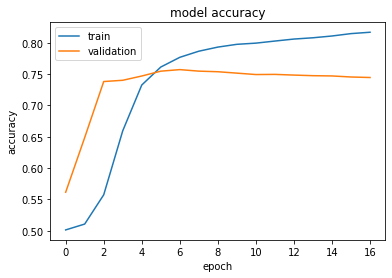

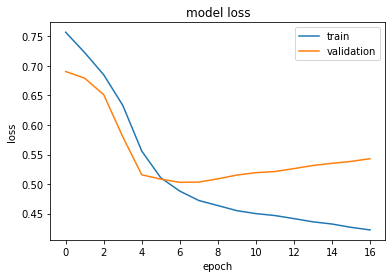

In [95]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Model 2 CNN with Word Embedded Glove 

In [217]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import sklearn
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import codecs
from tqdm import tqdm

In [218]:
data = pd.read_csv("cleaned_text.csv", encoding='latin1', header = 0)
data.drop(data.columns[[0]], axis=1, inplace=True)
data.dropna(subset = ["tweet"], inplace=True)
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0


In [219]:
tweets = data.tweet.copy()

In [220]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[1], char_list)

'work fun'

In [221]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [222]:
len(tweets_cleaned)

104742

In [223]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

tweets_tokens = tokenize(tweets_cleaned)

In [224]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

tweets_filtered = removeSW(tweets_tokens)

In [225]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)
    
    return texts_lem

nltk.download('wordnet')

tweets_lem = lemma(tweets_filtered)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [226]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [227]:
data['tweet'] = tweets_ready

In [228]:
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need,6,0
1,work,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke lighter,2,0
4,pass twit arriv trend topic,8,0


In [229]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300

In [230]:
%%time
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

400000it [00:31, 12695.47it/s]

Found 400000 word vectors.
Wall time: 31.6 s


In [231]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 24711


In [232]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(24711, 300)

In [233]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data['tweet'], data['sentiment'], test_size=0.2, random_state=42)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 83793
Test Data size 20949


In [234]:
BATCH_SIZE = 1024
EPOCHS = 30
MAX_SEQUENCE_LENGTH = 30

In [235]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (83793, 30)
Testing X Shape: (20949, 30)


In [236]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

es=EarlyStopping(monitor='val_loss',
                 mode='min',
                 verbose=1,
                 patience=10)

reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [198]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = Dropout(0.5)(x)

# Conv1D x2 + global max pooling
x = Conv1D(128, 7, activation="relu")(x)
x = Conv1D(128, 7, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_A = tf.keras.Model(inputs, outputs)

In [199]:
model_A.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [200]:
%%time 
history_A = model_A.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
82/82 [==============================] - 3s 26ms/step - loss: 0.6456 - accuracy: 0.6140 - val_loss: 0.5870 - val_accuracy: 0.6844
Epoch 2/30
82/82 [==============================] - 2s 23ms/step - loss: 0.5950 - accuracy: 0.6732 - val_loss: 0.5785 - val_accuracy: 0.6913uracy: 0.
Epoch 3/30
82/82 [==============================] - 2s 23ms/step - loss: 0.5781 - accuracy: 0.6920 - val_loss: 0.5677 - val_accuracy: 0.7006
Epoch 4/30
82/82 [==============================] - 2s 23ms/step - loss: 0.5661 - accuracy: 0.7012 - val_loss: 0.5642 - val_accuracy: 0.7035
Epoch 5/30
82/82 [==============================] - 2s 23ms/step - loss: 0.5543 - accuracy: 0.7102 - val_loss: 0.5635 - val_accuracy: 0.7029- loss: 0.5517 - accuracy:  - ETA: 0s - l - ETA: 0s - loss: 0.5543 - accuracy: 0.71
Epoch 6/30
82/82 [==============================] - 2s 23ms/step - loss: 0.5441 - accuracy: 0.7190 - val_loss: 0.5669 - val_accuracy: 0.7017 accuracy: 
Epoch 7/30
82/82 [==============================] -

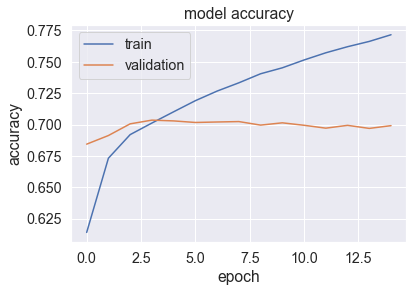

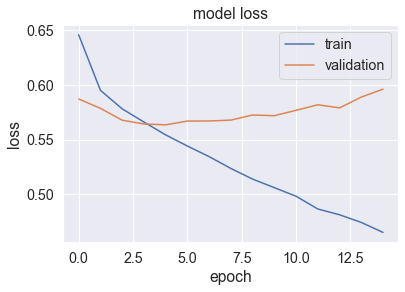

In [212]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history_A.history['accuracy'])
plt.plot(history_A.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history_A.history['loss'])
plt.plot(history_A.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Model 3 RNN

In [237]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_B = tf.keras.Model(inputs, outputs)

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [216]:
model_B.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'model_B' is not defined

In [ ]:
%%time
history_B = model_B.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

In [ ]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history_B.history['accuracy'])
plt.plot(history_A=B.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history_B.history['loss'])
plt.plot(history_B.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Traditional ML Models

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [42]:
#Random Forest Classifier
RF = RandomForestClassifier(max_depth=10)
RF.fit(Xtrain, ytrain)
y_pred = RF.predict(Xtest)
cm3 = confusion_matrix(y_pred, ytest)
total3=sum(sum(cm3))
Accuracy = (cm3[0,0]+cm3[1,1])/total3
Specificity = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print("Accuracy of  RFC :", Accuracy, "--Specificity of  RFC :", Specificity )

C:\Users\Mike\AppData\Local\Temp/ipykernel_6980/693845353.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(Xtrain, ytrain)


Accuracy of  RFC : 0.721609623371044 --Specificity of  RFC : 0.7563220940550133


In [25]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(Xtrain, ytrain)
y_pred = model5.predict(Xtest)
cm5 = confusion_matrix(y_pred, ytest)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )

C:\Users\Mike\.conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of  GaussianNB : 0.6781707957420402 --Sensitivity of  GaussianNB : 0.6545080279950597 --Specificity of  GaussianNB : 0.7108132666969559
